### Importing libs

In [19]:
from utils.data_set import get_data_json, extract_data_set_info
from utils.matrix import fix_diagonal_weight
from heuristics.closest_neighbor import closest_neighbor
from typing import Set, List, Tuple, Dict, Any
from itertools import product
import networkx as nx
import mip
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

#### Import data set

In [20]:
try:
    data_set = get_data_json("../../data/ReggioEmilia/4ReggioEmilia30.json")

    (num_vertices, demands, vehicle_capacity, distance_matrix) = extract_data_set_info(
        data_set
    )

    fix_diagonal_weight(distance_matrix)

    V = set(range(num_vertices))
    A = {(i, j): distance_matrix[i, j] for i in V for j in V}
    m = 1
    Q = vehicle_capacity
    q = demands
    c = distance_matrix
except Exception as e:
    raise e

2024-09-09 08:29:43.932 | SUCCESS  | utils.data_set:get_data_json:23 - JSON file loaded correctly


#### Visualize the distance matrix as a DataFrame

In [21]:
df = pd.DataFrame(c)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0,3700,4000,3900,4900,3900,4800,3800,4000,2600,4600,3800,3000,3500
1,4300,0,1300,300,2400,1200,1300,2600,1600,1200,1000,600,1400,800
2,4500,900,0,900,2100,900,1000,1900,1300,2100,700,1400,2200,500
3,4500,300,1300,0,2200,1200,1000,2500,1600,1500,700,800,1600,800
4,5500,2200,2600,2000,0,3100,1200,3600,3200,2500,1800,2000,2600,2700
5,3700,800,900,1100,2900,0,1800,1500,500,2000,1500,1300,1700,400
6,5300,1400,1800,1100,2000,2300,0,2700,2300,2200,900,1800,2400,1900
7,3500,2200,1700,2400,3600,1500,2400,0,1400,3000,2400,2600,2700,1800
8,4300,800,1100,1000,3100,1000,2000,1500,0,1600,1700,1200,1300,600
9,3300,1600,2600,1800,2300,2500,2200,3000,2700,0,2100,1200,800,2100


#### Creating model instance

In [22]:
model = mip.Model(sense=mip.MINIMIZE, solver_name=mip.CBC)

#### Define binary and continuous decision variables

In [23]:
x: Dict[Tuple[int, int], mip.Var] = {
    (i, j): model.add_var(name=f"x_{i}_{j}", var_type=mip.BINARY) for (i, j) in A
}

f = {
    (i, j): model.add_var(name=f"f_{i}_{j}", var_type=mip.CONTINUOUS)
    for i in V
    for j in V
}

#### Set the objective function to minimize total distance

In [24]:
model.objective = mip.minimize(mip.xsum(cost * x[i, j] for (i, j), cost in A.items()))

#### Set the m-TSP essential constraints

In [25]:
model += mip.xsum(x[i, i] for i in V) == 0

for j in V - {0}:
    model += mip.xsum(x[i, j] for i in V) == 1  # Inflow
    model += mip.xsum(x[j, i] for i in V) == 1  # Outflow

model += mip.xsum(x[0, j] for j in V - {0}) <= m  # Vehicle limit

model += (
    mip.xsum(x[0, j] for j in V - {0}) - mip.xsum(x[j, 0] for j in V - {0}) == 0
)  # All vehicles used must return to depot

#### Add flow conservation and vehicle capacity constraints

In [26]:
model += mip.xsum(f[i, i] for i in V) == 0

for j in V - {0}:
    model += (
        mip.xsum(f[j, i] for i in V if i != j) - mip.xsum(f[i, j] for i in V if i != j)
        == q[j]
    )

for i in V:
    for j in V:
        if i != j:
            flow_lower_bound = max(0, q[i], -q[j]) * x[i, j]
            flow_upper_bound = min(Q, Q + q[i], Q - q[j]) * x[i, j]

            model += f[i, j] >= flow_lower_bound
            model += f[i, j] <= flow_upper_bound

#### Generate an initial solution using closest neighbor heuristics

In [27]:
def generate_initial_solution(
    stations: Set[int],
    demands: List[int],
    distance_matrix: np.matrix,
    vehicle_capacity: int,
    x: Dict[Tuple[int, int], mip.Var],
) -> List[Tuple[mip.Var, int]]:
    depot = 0
    customers = list(stations - {depot})
    demand_dict = dict(enumerate(demands))
    routes = closest_neighbor(
        depot, customers, demand_dict, distance_matrix, vehicle_capacity
    )

    initial_solution: List[Tuple[mip.Var, int]] = []
    for route in routes:
        for i, j in zip(route, route[1:]):
            initial_solution.append((x[i, j], 1))

    return initial_solution

In [28]:
initial_solution = generate_initial_solution(V, q, c, Q, x)

#### Implement separation procedure for subtour elimination

In [29]:
class SeparationProcedure(mip.ConstrsGenerator):
    def __init__(
        self,
        V: Set[int],
        A: Dict[Tuple[int, int], Any],
        q: List[int],
        Q: int,
        x: Dict[Tuple[int, int], mip.Var],
    ):
        self.V = V
        self.A = A
        self.x = x
        self.q = q
        self.Q = Q

    def generate_constrs(self, model: mip.Model, depth: int = 0, npass: int = 0):
        vertices = self.V
        cut_pool = mip.CutPool()
        depot = 0
        y = model.translate(self.x)

        G_prime = nx.DiGraph()
        G_prime.add_nodes_from(vertices)

        arcs_prime = [
            (i, j) for i, j in product(vertices, vertices) if i != j and y[i, j]
        ]

        for u, v in arcs_prime:
            G_prime.add_edge(u, v, capacity=y[u, v].x)

        for node in vertices - {depot}:
            flow_value, _ = nx.maximum_flow(G_prime, depot, node)

            if flow_value < 1:
                _, (S, _) = nx.minimum_cut(G_prime, depot, node)

                tour = [
                    (y[i, j], y[i, j].x)
                    for i, j in product(vertices, vertices)
                    if i != j and y[i, j] and i in S and j in S
                ]

                if sum(value for _, value in tour) >= (len(S) - 1) + 1e-4:
                    cut = mip.xsum(1 * var for var, _ in tour) <= len(S) - 1
                    cut_pool.add(cut)

                total_demand = abs(sum(self.q[i] for i in S))
                min_vehicles = math.ceil(total_demand / self.Q)

                if min_vehicles < flow_value:
                    if (
                        sum(value for _, value in tour)
                        >= (len(S) - max(1, min_vehicles)) + 1e-4
                    ):
                        stronger_cut = mip.xsum(1 * var for var, _ in tour) <= len(
                            S
                        ) - max(1, min_vehicles)
                        cut_pool.add(stronger_cut)

        for cut in cut_pool.cuts:
            model += cut

In [30]:
model.start = initial_solution
model.cuts_generator = SeparationProcedure(V, A, q, Q, x)
model.optimize()

Starting solution of the Linear programming relaxation problem using Dual Simplex

Clp0024I Matrix will be packed to eliminate 53 small elements
Coin0506I Presolve 352 (-55) rows, 364 (-28) columns and 1337 (-107) elements
Clp0014I Perturbing problem by 0.001% of 1185.116 - largest nonzero change 0.018057765 ( 0.0062715758%) - largest zero change 0.0025461185
Clp0006I 0  Obj 0 Primal inf 79.838026 (39)
Clp0000I Optimal - objective value 16561.996
Coin0511I After Postsolve, objective 16561.996, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 16561.99582 - 210 iterations time 0.002, Presolve 0.00

Starting MIP optimization
Cgl0002I 14 variables fixed
Cgl0004I processed model has 339 rows, 351 columns (182 integer (182 of which binary)) and 1623 elements
Coin3009W Conflict graph built in 0.000 seconds, density: 0.927%
Cgl0015I Clique Strengthening extended 0 cliques, 0 were dominated
Cbc0045I Fixing only non-zero variables.
Cbc0045I Warning: mipstart values could not

<OptimizationStatus.OPTIMAL: 0>

In [31]:
if model.num_solutions:
    model.check_optimization_results()

    optimal_route = [
        (origin, destination)
        for origin in V
        for destination in V
        if x[origin, destination].x == 1
    ]

    optimal_flow = [
        (origin, destination)
        for origin in V
        for destination in V
        if f[origin, destination].x and x[origin, destination].x >= 0.5
    ]

    for origin, destination in optimal_route:
        variable_name = f"x_{origin}_{destination}"
        variable_value = x[origin, destination].x
        print(f"{model.var_by_name(variable_name)} = {variable_value}")

x_0_7 = 1.0
x_1_11 = 1.0
x_2_10 = 1.0
x_3_1 = 1.0
x_4_6 = 1.0
x_5_8 = 1.0
x_6_3 = 1.0
x_7_5 = 1.0
x_8_13 = 1.0
x_9_12 = 1.0
x_10_4 = 1.0
x_11_9 = 1.0
x_12_0 = 1.0
x_13_2 = 1.0


In [32]:
print("Initial demand at each station:")
for station, demand in enumerate(q):
    print(f"Station {station}: {demand}")


Initial demand at each station:
Station 0: 0
Station 1: -3
Station 2: 1
Station 3: 2
Station 4: -5
Station 5: 2
Station 6: -10
Station 7: -2
Station 8: -2
Station 9: 3
Station 10: -1
Station 11: -6
Station 12: -9
Station 13: 2


In [33]:
print("Optimal flow between stations:")
for origin, destination in optimal_flow:
    flow_var_name = f"f_{origin}_{destination}"
    flow_value = f[origin, destination].x
    print(f"Flow from Station {origin} to Station {destination}: {flow_value}")

Optimal flow between stations:
Flow from Station 0 to Station 7: 28.0
Flow from Station 1 to Station 11: 12.0
Flow from Station 2 to Station 10: 29.0
Flow from Station 3 to Station 1: 15.0
Flow from Station 4 to Station 6: 23.0
Flow from Station 5 to Station 8: 28.0
Flow from Station 6 to Station 3: 13.0
Flow from Station 7 to Station 5: 26.0
Flow from Station 8 to Station 13: 26.0
Flow from Station 9 to Station 12: 9.0
Flow from Station 10 to Station 4: 28.0
Flow from Station 11 to Station 9: 6.0
Flow from Station 13 to Station 2: 28.0


In [34]:
def plot_route(V, route, pos=None):
    G = nx.DiGraph()
    G.add_nodes_from(V)
    G.add_edges_from(route)

    if pos is None:
        pos = nx.spring_layout(G)

    plt.figure(figsize=(12, 8))

    # Draw all nodes except 0 in light blue
    nx.draw_networkx_nodes(
        G, pos, nodelist=set(V) - {0}, node_color="lightblue", node_size=500
    )

    # Draw node 0 in red
    nx.draw_networkx_nodes(G, pos, nodelist=[0], node_color="red", node_size=500)

    nx.draw_networkx_labels(G, pos)

    # Draw edges
    nx.draw_networkx_edges(G, pos, edgelist=route, edge_color="grey", arrows=True)

    # Add edge labels (distances)
    edge_labels = {(i, j): f"{c[i,j]}" for i, j in route}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    plt.title("Bike-sharing System Route")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

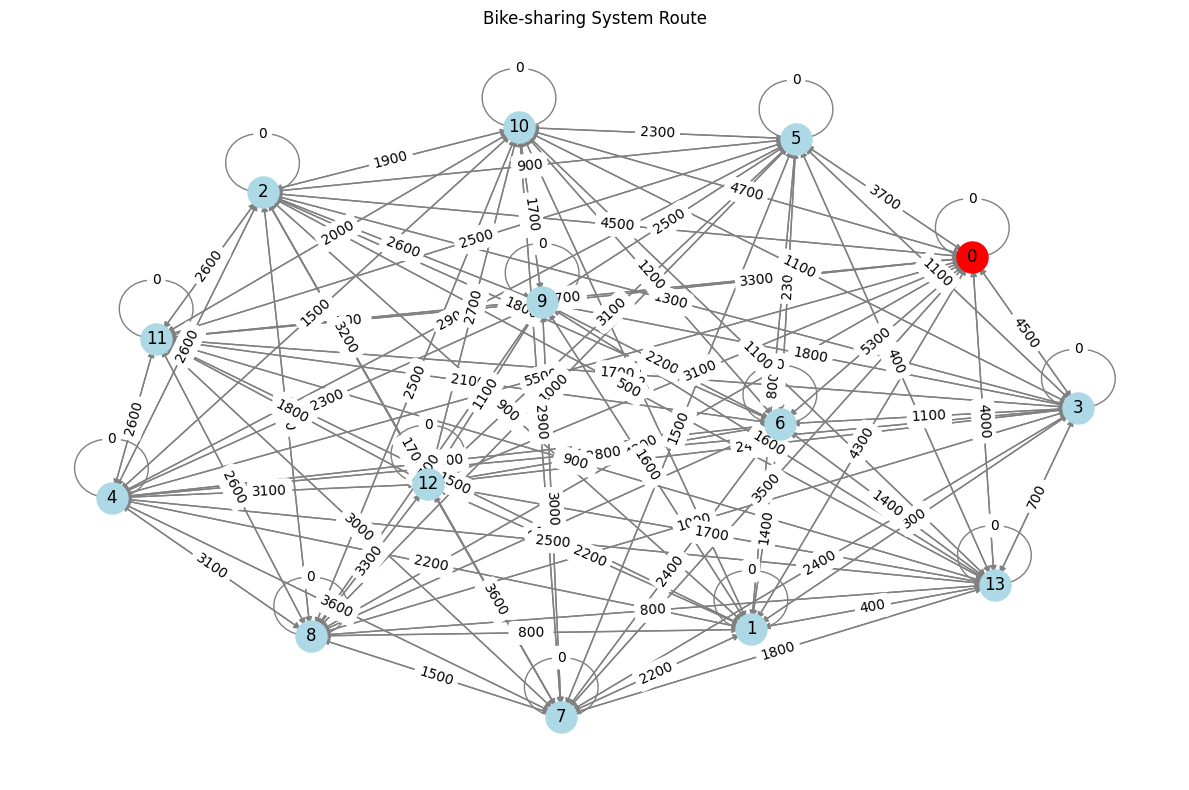

In [35]:
plot_route(V, A)

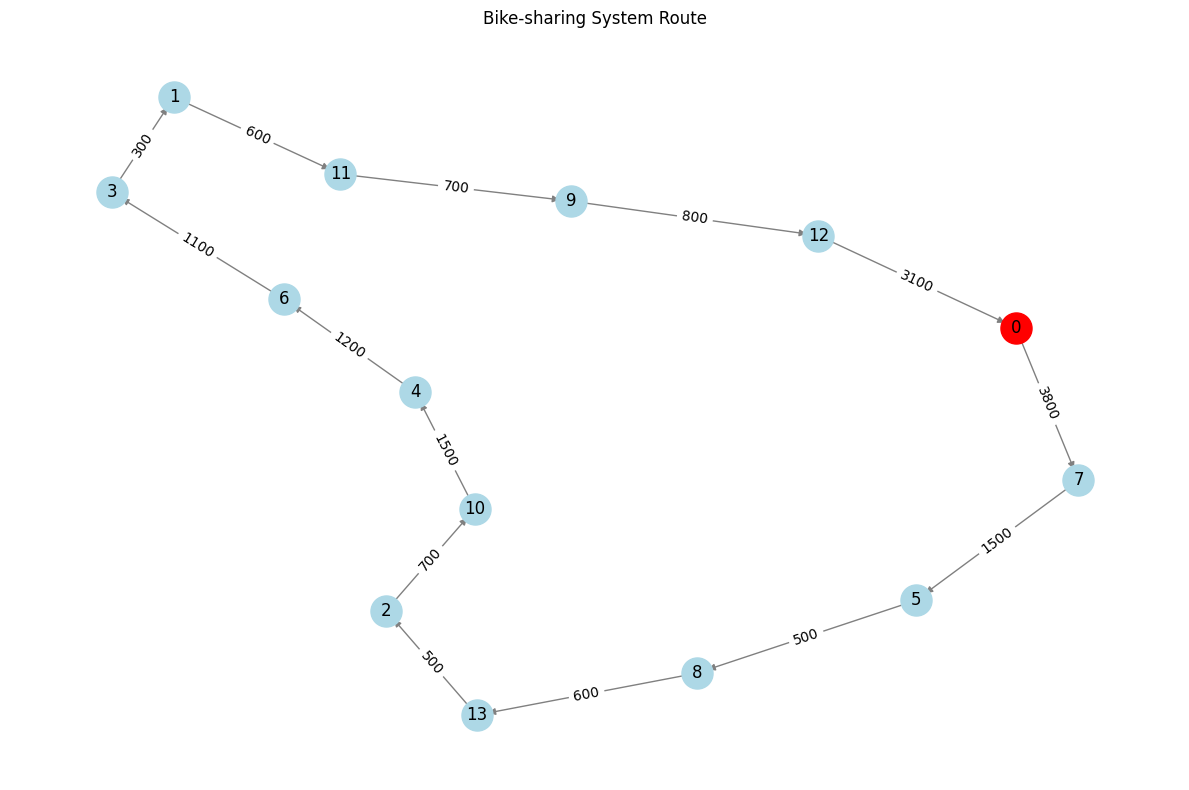

In [36]:
plot_route(V, optimal_route)